## Machine Learning using LSTM on Split 3

In [1]:
# Warnings are provided to warn the developer of situations that aren’t necessarily exceptions. 
#Usually, a warning occurs when there is some obsolete of certain programming elements.
#Python program terminates immediately if an error occurs. Conversely, a warning is not critical.

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

2023-05-25 15:40:55.314857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Importing the stored components

In [3]:
%store -r scaler
%store -r input_col1
input_col = input_col1
%store -r target_col1
target_col = target_col1

In [4]:
# Retrieve stored variables
%store -r x_train1
x_train = x_train1

%store -r y_train1
y_train = y_train1

%store -r x_val1
x_val = x_val1

%store -r y_val1
y_val = y_val1

%store -r x_test1
x_test = x_test1

%store -r y_test1
y_test = y_test1

### Creating sequences for the training set, validation set and test set to fit into the LSTM

In [5]:
def create_sequences(data, target, seq_length, output_steps):
    X = []
    y = []

    for i in range(data.shape[0] - seq_length - output_steps + 1):
        seq = data[i:i + seq_length]
        X.append(seq)
        y.append(target[i + seq_length:i + seq_length + output_steps])

    return np.array(X), np.array(y)

sequence_length = 50
output_steps = 1

X_train_seq, y_train_seq = create_sequences(x_train, y_train, sequence_length, output_steps)
X_val_seq, y_val_seq = create_sequences(x_val, y_val, sequence_length, output_steps)
X_test_seq, y_test_seq = create_sequences(x_test, y_test, sequence_length, output_steps)

#### Layers of the LSTM Model

In [ ]:
n_features = X_train_seq.shape[2]

model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(sequence_length, n_features), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(output_steps))

### Summary of the LSTM Model

In [ ]:
model.summary()

### This will run the number of epochs

In [ ]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)


In [ ]:
model.save('LSTM Train Split 3.h5')

### Saving in order to skip the time consuming training

In [30]:
loaded_model = load_model('LSTM Train Split 3.h5')

### Predict the validation set and calculate the error metrics and r^2 score

In [10]:
# Make predictions using the model
y_pred = loaded_model.predict(X_val_seq)

# Flatten y_val_seq and y_pred for error calculations
y_val_seq_flat = y_val_seq.flatten()
y_pred_flat = y_pred.flatten()

# Calculate MSE
mse = mean_squared_error(y_val_seq_flat, y_pred_flat)

# Calculate RMSE
rmse = sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_val_seq_flat, y_pred_flat)

# Calculate R2 Score
r2 = r2_score(y_val_seq_flat, y_pred_flat)

print("Validation MSE:", mse)
print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R2 Score:", r2)

997/997 [==============================] - 11s 11ms/step
Validation MSE: 0.0009052008514224118
Validation RMSE: 0.03008655599137947
Validation MAE: 0.013154182528797489
Validation R2 Score: 0.8743595136722888


### Predict the test set and calculate the error metrics and r^2 score

In [11]:
test_loss = loaded_model.evaluate(X_test_seq, y_test_seq)
print(f'Test loss: {test_loss}')

1996/1996 [==============================] - 19s 9ms/step - loss: 0.0018
Test loss: 0.001751353032886982


In [12]:
y_pred = loaded_model.predict(X_test_seq)

1996/1996 [==============================] - 19s 9ms/step


In [13]:
# Reshape the predictions and true values to calculate the metrics
y_test_reshaped = y_test_seq.reshape(-1)
y_pred_reshaped = y_pred.reshape(-1)

mae = mean_absolute_error(y_test_reshaped, y_pred_reshaped)
mse = mean_squared_error(y_test_reshaped, y_pred_reshaped)
rmse = sqrt(mse)
r2 = r2_score(y_test_reshaped, y_pred_reshaped)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'r2 score: {r2}')

Mean Absolute Error: 0.018462500375784483
Mean Squared Error: 0.0017513523771411099
Root Mean Squared Error: 0.041849162203574757
r2 score: 0.8210180896119608


### Set True or False to the scaling to see the actual values or the scaled values

In [15]:
def invert_scaling(y_values, scaler, target_index, apply_inverse=True):
    if apply_inverse:
        # Prepare matrix with zeros to match dimensions
        temp_matrix = np.zeros((y_values.shape[0], scaler.n_features_in_))
        temp_matrix[:, target_index] = y_values.reshape(-1)
        y_values_inverted = scaler.inverse_transform(temp_matrix)[:, target_index]
    else:
        y_values_inverted = y_values
    return y_values_inverted

# Set apply_inverse to False if you want scaled values, True if you want real values
apply_inverse = False

# Assuming your 'DownholePressure' is the 5th column in your dataframe, change this index accordingly
target_index = 5

# Take the last column of y_pred and y_test_seq
y_pred_last_col = y_pred[:, -1]
y_test_last_col = y_test_seq[:, -1]

y_pred_inverted = invert_scaling(y_pred_last_col, scaler, target_index, apply_inverse)
y_test_inverted = invert_scaling(y_test_last_col, scaler, target_index, apply_inverse)

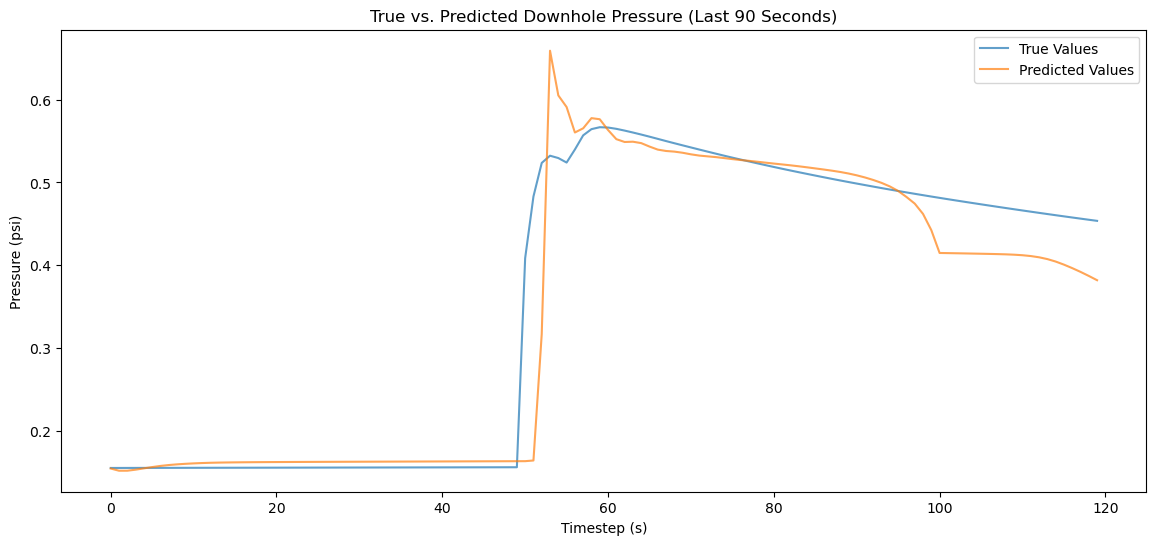

In [16]:
# Select the first 90 steps
y_test_inverted_90 = y_test_reshaped[70:190]
y_pred_inverted_90 = y_pred_reshaped[70:190]

plt.figure(figsize=(14, 6))
plt.plot(y_test_inverted_90, label='True Values', alpha=0.7)
plt.plot(y_pred_inverted_90, label='Predicted Values', alpha=0.7)
plt.xlabel('Timestep (s)')
plt.ylabel('Pressure (psi)')
plt.title('True vs. Predicted Downhole Pressure (Last 90 Seconds)')
plt.legend()
plt.show()

### Importing new online dataset

In [23]:
%store -r df_validation1
df_validation = df_validation1

In [24]:
# 1. Make sure your df_validation only contains the input features
X_validation = df_validation[input_col].to_numpy()
y_validation = df_validation[target_col].to_numpy()

# 2. Create sequences from the scaled validation data
sequence_length = 50
output_steps = 1  # Add this line if you haven't defined output_steps already
X_validation_seq, _ = create_sequences(X_validation, np.zeros(X_validation.shape[0]), sequence_length, output_steps)

# 3. Use the LSTM model to predict the DownholePressure values for each sequence
y_pred_validation = loaded_model.predict(X_validation_seq)

18/18 [==============================] - 0s 11ms/step


In [25]:
# Compute error metrics only for the data points where we have predictions
y_validation = y_validation[:len(y_pred_validation)]

# Compute MSE
mse = mean_squared_error(y_validation, y_pred_validation)

# Compute RMSE
rmse = np.sqrt(mse)

# Compute MAE
mae = mean_absolute_error(y_validation, y_pred_validation)

# Compute R2 Score
r2 = r2_score(y_validation, y_pred_validation)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

MSE: 0.007710859243722273
RMSE: 0.08781149835711877
MAE: 0.06756953176774111
R2 Score: -0.7837799914177472


### Unscale the values

In [26]:
# 4. Invert the scaling of the predicted DownholePressure values
target_index = 5
y_pred_validation_last_col = y_pred_validation[:, -1].reshape(-1, 1)
y_pred_validation_inverted = scaler.inverse_transform(np.concatenate((np.zeros((y_pred_validation_last_col.shape[0], target_index)), y_pred_validation_last_col, np.zeros((y_pred_validation_last_col.shape[0], scaler.n_features_in_ - target_index - 1))), axis=1))[:, target_index]

y_validation = df_validation[target_col].to_numpy()

# Invert the scaling of the true DownholePressure values
y_validation_last_col = y_validation.reshape(-1, 1)
y_validation_inverted = scaler.inverse_transform(np.concatenate((np.zeros((y_validation_last_col.shape[0], target_index)), y_validation_last_col, np.zeros((y_validation_last_col.shape[0], scaler.n_features_in_ - target_index - 1))), axis=1))[:, target_index]


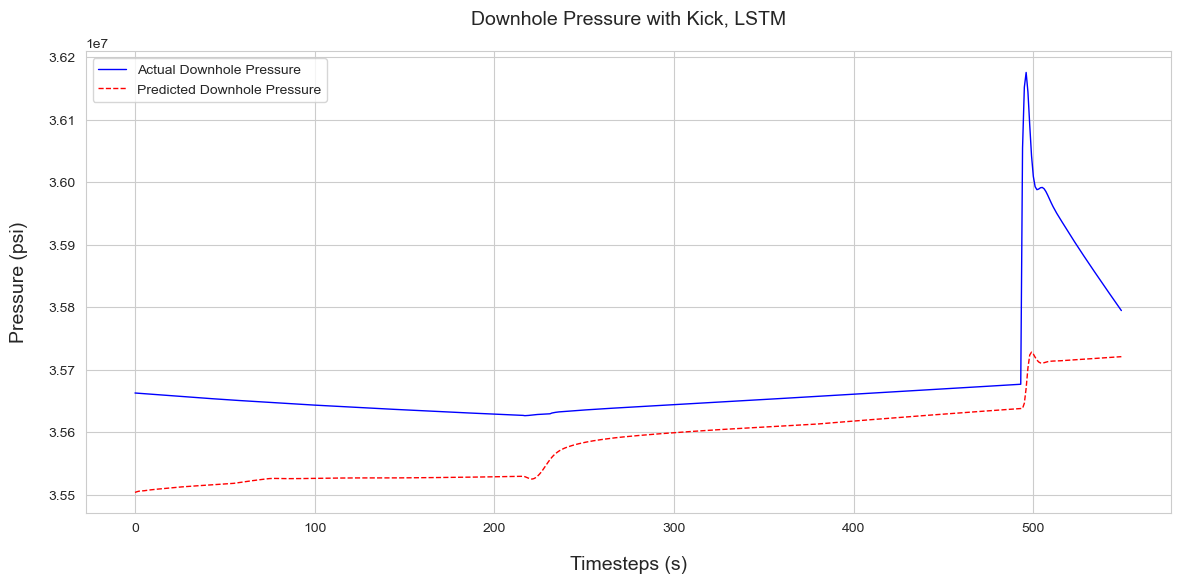

In [28]:
# Assuming your dataset has a time resolution of 'delta_t' seconds
delta_t = 1  # Replace this value with the actual time resolution in seconds

# Calculate the number of timesteps corresponding to 90 seconds
timesteps_in_90_seconds = int(550 / delta_t)

# Calculate the number of sequences corresponding to 90 seconds
sequences_in_90_seconds = timesteps_in_90_seconds // output_steps

# Select the last 'sequences_in_90_seconds' sequences from y_validation_inverted and y_pred_validation_inverted
y_validation_last_90_seconds = y_validation_inverted[-sequences_in_90_seconds * output_steps:]
y_pred_validation_last_90_seconds = y_pred_validation_inverted[-sequences_in_90_seconds * output_steps:]

# Set the alpha value you want for your gridlines. 1 is opaque, 0 is transparent
alpha = 0.3

# Get the grid color
gridcolor = mpl.rcParams['grid.color']

# Convert the grid color to RGBA
rgba = mcolors.to_rgba(gridcolor)

# Create a new color with the adjusted alpha
new_color = (rgba[0], rgba[1], rgba[2], alpha)

# Convert the new color back to a hex string
new_color_hex = mcolors.to_hex(new_color)

# Set the new grid color
mpl.rcParams['grid.color'] = new_color_hex

sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

# Create line plot for true values with thinner line
sns.lineplot(data=y_validation_last_90_seconds, label='Actual Downhole Pressure', color='blue', linewidth=1)

# Create line plot for predicted values with thinner line
sns.lineplot(data=y_pred_validation_last_90_seconds, label='Predicted Downhole Pressure', color='red', linewidth=1, linestyle='--')

plt.xlabel('Timesteps (s)', fontsize=14, labelpad=15)
plt.ylabel('Pressure (psi)', fontsize=14, labelpad=15)
plt.title('Downhole Pressure with Kick, LSTM', fontsize=14, pad=20)
plt.legend(fontsize=10)

plt.show()

### Simple Kick Detection Trend Analysis

In [29]:
# Set the shift value manually
shift_value = 50  # You can adjust this value to properly align the predicted values with the true values

# Generate x-axis values for true and predicted values
x_true = np.arange(len(y_validation_inverted))
x_pred = np.arange(shift_value, shift_value + len(y_pred_validation_inverted))

# Calculate the upper and lower bounds with a 1% threshold
threshold = 0.01
upper_bound = y_pred_validation_inverted * (1 + threshold)
lower_bound = y_pred_validation_inverted * (1 - threshold)

# Calculate the derivative of the predicted values
y_pred_derivative = np.gradient(y_pred_validation_inverted)

# Set a threshold for the rate of change
roc_threshold = 0.02  # Adjust this value based on your specific use case

# Calculate the upper and lower bounds for the rate of change
roc_upper_bound = y_pred_derivative * (1 + roc_threshold)
roc_lower_bound = y_pred_derivative * (1 - roc_threshold)

# Plot the true values
plt.figure(figsize=(12, 6))
plt.plot(x_true, y_validation_inverted, label='True values', color='blue')

# Initialize a variable to keep track of whether a "KICK" sign has been added to the plot
kick_added = False

# Fill the entire plot area with green
plt.axvspan(0, len(x_true), facecolor='green', alpha=0.2)

# Fill the plot area with red when the predicted values cross the band or the rate of change threshold
for i in range(shift_value, len(x_pred) + shift_value):
    if y_pred_validation_inverted
        if y_pred_validation_inverted[i] > upper_bound[i - shift_value] or y_pred_validation_inverted[i] < lower_bound[i - shift_value] or y_pred_derivative[i - shift_value] > roc_upper_bound[i - shift_value] or y_pred_derivative[i - shift_value] < roc_lower_bound[i - shift_value]:
        plt.axvspan(i, i + 1, facecolor='red', alpha=0.2)
        if not kick_added:
            plt.text(i, y_pred_validation_inverted[i - shift_value] + 0.1, 'KICK')
            kick_added = True

# Plot the predicted values without the band
plt.plot(x_pred, y_pred_validation_inverted, label='Predicted values', color='red', linestyle='--')

plt.xlabel('Timesteps')
plt.ylabel('Downhole Pressure')
plt.title('Downhole Pressure: True vs. Predicted (All 600 Timesteps) with Kick Indication')
plt.legend()

# Set the x-axis limits to display only the 0-600 range
plt.xlim(0, 600)

plt.show()


SyntaxError: invalid syntax (3093702033.py, line 35)